In [10]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import sys
sys.path.append('../')
from utilities import FCFFNet, UnitGaussianNormalizer, MatReader
from banana import banana_posterior

from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [12]:
# set parameters
opt_normalize = 1.0

# set device
device = torch.device('cpu')

# set dimension
dy = 2

# Load the data
Ntrain = int(10000)
loader = MatReader('banana.mat')
y_train = loader.read_field('y_prime')[0:Ntrain,:].contiguous()
y_train_test = loader.read_field('y_primetest')[0:Ntrain,:].contiguous()

# define true distribution
ban = banana_posterior()

In [14]:
def plot_results(Fz, y_train_test, file_name, bandwidth=None):
    
    # use grid search cross-validation to optimize the bandwidth
    if bandwidth == None:
        params = {'bandwidth': np.linspace(0.05, 0.15, 10)}
        grid = GridSearchCV(KernelDensity(), params, cv=5)
        grid.fit(Fz)
        print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
        bandwidth = grid.best_estimator_.bandwidth
    
    #Compute KL error between pdfs
    kde_kernel = stats.gaussian_kde(Fz.T)
    kde_kernel.set_bandwidth(bandwidth)#grid.best_estimator_.bandwidth)
    approx_pdf = kde_kernel(y_train_test.T)
    true_pdf   = ban.prior_pdf(y_train_test)
    z = np.log(true_pdf) - np.log(approx_pdf)
    z = z[np.isnan(z) == False]
    z = z[np.isinf(z) == False]
    kl_error = np.mean(z)
    kl_error_stde = 1.96*np.std(z)/np.sqrt(Ntest)
    print('KL: %f pm %f' % (kl_error, kl_error_stde))

    # define grid
    x1_dom = [-3,3]
    x2_dom = [-1,6]
    xx1 = np.linspace(x1_dom[0], x1_dom[1], 100)
    xx2 = np.linspace(x2_dom[0], x2_dom[1], 100)
    Xgrid1, Xgrid2 = np.meshgrid(xx1,xx2)
    X12 = np.vstack([Xgrid1.ravel(), Xgrid2.ravel()]).T

    # evaluate true and approximate pdf on a grid
    true_pdf = ban.prior_pdf(X12)
    true_pdf = np.reshape(true_pdf, (Xgrid1.shape))

    approx_pdf_grid = kde_kernel(X12.T)
    approx_pdf_grid = np.reshape(approx_pdf_grid.T, Xgrid1.shape)
    
    plt.figure(figsize=[4,4])
    plt.contourf(xx1,xx2,true_pdf,cmap=plt.cm.Blues)
    plt.xlabel('$x_1$', size=20)
    plt.ylabel('$x_2$', size=20)
    plt.xlim((x1_dom[0], x1_dom[1]))
    plt.ylim((x2_dom[0], x2_dom[1]))
    plt.clim((0,0.32))
    plt.colorbar()
    plt.savefig('true_density.png',dpi=400, bbox_inches='tight')

    plt.figure(figsize=[4,4])
    plt.contourf(xx1,xx2,np.zeros(true_pdf.shape),cmap=plt.cm.Blues)
    plt.plot(Fz[:,0],Fz[:,1],'.r',markersize=.1,fillstyle='full')
    plt.xlabel('$x_1$', size=20)
    plt.ylabel('$x_2$', size=20)
    plt.xlim((x1_dom[0], x1_dom[1]))
    plt.ylim((x2_dom[0], x2_dom[1]))
    plt.clim((0,0.32))
    plt.savefig(file_name + '_density.png',dpi=400, bbox_inches='tight')

## Compare all files

KL: 0.055827 pm 0.002618


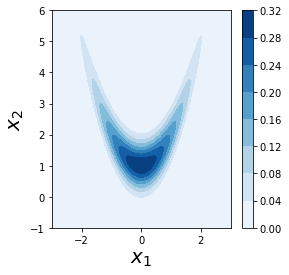

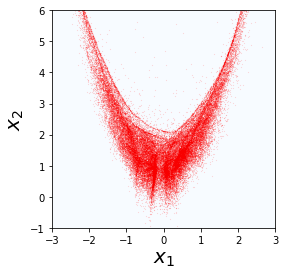

In [16]:
######### MGAN #########

# define and load network
file_name = 'mgan_banana_l01_norm'
F = FCFFNet([2, 32, 64, 32, 2], nn.LeakyReLU, nonlinearity_params=[0.2, True]).to(device)
F.load_state_dict(torch.load(file_name + '_F.pt'))

#Normalize the marginals to have zero mean and unit std
if opt_normalize > 0.0:
    y_norm = UnitGaussianNormalizer(y_train)
    
# sample from conditional
Ntest = int(5e4)
z = torch.randn(Ntest, dy, device=device)
with torch.no_grad():
    Fz = F(z)
#Undo normalizations
if opt_normalize > 0.0:
    Fz = y_norm.decode(Fz)
Fz = Fz.cpu().numpy()

# generate plots
plot_results(Fz, y_train_test, file_name, bandwidth=0.095)

KL: 0.059757 pm 0.002414


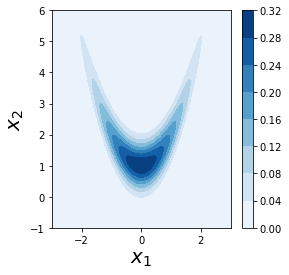

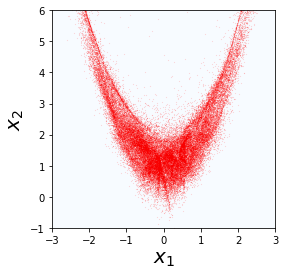

In [17]:
######### MGAN REVERSE #########

# define and load network
file_name = 'mgan_rev_banana_l01_norm'
F = FCFFNet([2, 32, 64, 32, 2], nn.LeakyReLU, nonlinearity_params=[0.2, True]).to(device)
F.load_state_dict(torch.load(file_name + '_F.pt'))

#Normalize the marginals to have zero mean and unit std
if opt_normalize > 0.0:
    y_train_t = torch.fliplr(y_train)
    y_norm = UnitGaussianNormalizer(y_train_t)
    
# sample from conditional
Ntest = int(5e4)
z = torch.randn(Ntest, dy, device=device)
with torch.no_grad():
    Fz = F(z)
#Undo normalizations
if opt_normalize > 0.0:
    Fz = y_norm.decode(Fz)
Fz = torch.fliplr(Fz)
Fz = Fz.cpu().numpy()

# generate plots
plot_results(Fz, y_train_test, file_name, bandwidth=0.105)

KL: 0.045138 pm 0.006587


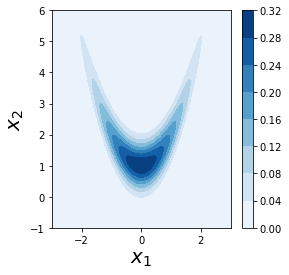

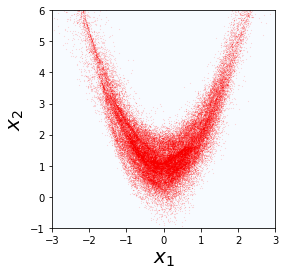

In [18]:
######### MGAN TRI #########

# define and load network
file_name = 'mgantri_banana_l01_norm'
F1 = FCFFNet([1, 22, 46, 22, 1], nn.LeakyReLU, nonlinearity_params=[0.2, True]).to(device)
F2 = FCFFNet([2, 22, 46, 22, 1], nn.LeakyReLU, nonlinearity_params=[0.2, True]).to(device)
F1.load_state_dict(torch.load(file_name + '_F1.pt'))
F2.load_state_dict(torch.load(file_name + '_F2.pt'))

#Normalize the marginals to have zero mean and unit std
if opt_normalize > 0.0:
    y_norm = UnitGaussianNormalizer(y_train)
    
# sample from conditional
Ntest = int(5e4)
z = torch.randn(Ntest, dy, device=device)
with torch.no_grad():
    Fz = torch.cat((F1(z[:,0].unsqueeze(1)), F2(z)), 1)
#Undo normalizations
if opt_normalize > 0.0:
    Fz = y_norm.decode(Fz)
Fz = Fz.cpu().numpy()

# generate plots
plot_results(Fz, y_train_test, file_name, bandwidth=0.083)

KL: 0.103478 pm 0.004065


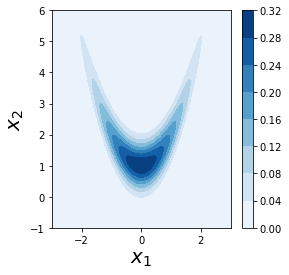

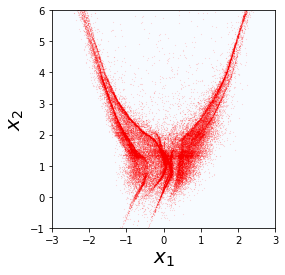

In [19]:
######### MGAN TRI REVERSE #########

# define and load network
file_name = 'mgantri_rev_banana_l01_norm'
F1 = FCFFNet([1, 22, 46, 22, 1], nn.LeakyReLU, nonlinearity_params=[0.2, True]).to(device)
F2 = FCFFNet([2, 22, 46, 22, 1], nn.LeakyReLU, nonlinearity_params=[0.2, True]).to(device)
F1.load_state_dict(torch.load(file_name + '_F1.pt'))
F2.load_state_dict(torch.load(file_name + '_F2.pt'))

#Normalize the marginals to have zero mean and unit std
if opt_normalize > 0.0:
    y_train_t = torch.fliplr(y_train)
    y_norm = UnitGaussianNormalizer(y_train_t)
    
# sample from conditional
Ntest = int(5e4)
z = torch.randn(Ntest, dy, device=device)
with torch.no_grad():
    Fz = torch.cat((F1(z[:,0].unsqueeze(1)), F2(z)), 1)
#Undo normalizations
if opt_normalize > 0.0:
    Fz = y_norm.decode(Fz)
Fz = torch.fliplr(Fz)
Fz = Fz.cpu().numpy()

# generate plots
plot_results(Fz, y_train_test, file_name, bandwidth=0.072)